In [1]:
# Import necessary libraries
import torch               # Import PyTorch library
import torch.nn as nn      # Import PyTorch's neural network module
import torch.nn.functional as F  # Import PyTorch's functional interface
import numpy as np         # Import NumPy library for numerical operations
import matplotlib.pyplot as plt  # Import Matplotlib library for plotting
from IPython import display  # Import IPython's display module for visualization
display.set_matplotlib_formats('svg')  # Set Matplotlib to display SVG images for better quality

from sklearn.model_selection import train_test_split  # Import train_test_split from scikit-learn for data splitting
from torch.utils.data import DataLoader, TensorDataset  # Import DataLoader and TensorDataset from PyTorch for working with data


C:\Users\fafzali\AppData\Local\Temp\ipykernel_6980\2403366663.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')  # Set Matplotlib to display SVG images for better quality


# Create the data

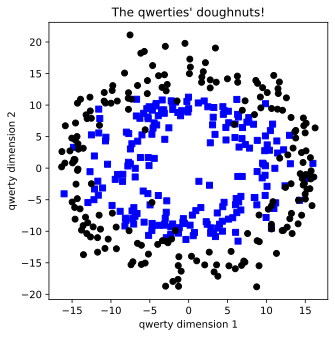

In [2]:
# Define the number of data points per cluster
nPerClust = 200

# Create an array of angles ranging from 0 to 4π
th = np.linspace(0, 4*np.pi, nPerClust)

# Set radii for two clusters
r1 = 10
r2 = 15

# Generate data for the first cluster (a)
a = [r1*np.cos(th) + np.random.randn(nPerClust)*3,
     r1*np.sin(th) + np.random.randn(nPerClust)]

# Generate data for the second cluster (b)
b = [r2*np.cos(th) + np.random.randn(nPerClust),
     r2*np.sin(th) + np.random.randn(nPerClust)*3]

# Create true labels, where 0 represents the first cluster and 1 represents the second cluster
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))

# Concatenate data points into a matrix
data_np = np.hstack((a, b)).T

# Convert the data and labels to PyTorch tensors
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# Plot the data points
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'bs')
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()


# Separate the data into DataLoaders

In [3]:
# Use scikit-learn to split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)
# This function from scikit-learn takes the data and labels arrays and splits them into training and testing sets.
# The test_size parameter specifies that 20% of the data should be reserved for testing, while 80% is used for training.

# Convert the training and testing data into PyTorch TensorDatasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)
# These lines create PyTorch TensorDatasets for both training and testing data.
# TensorDataset is a PyTorch class that allows you to combine data tensors and their corresponding label tensors.

# Set the batch size for training data (16 in this case)
batchsize = 16
# The batchsize variable is set to 16, determining the number of data points in each batch during training.
# Batching helps in efficient training of deep learning models.

# Create DataLoader objects to manage batches of data during training and testing
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
# These lines create DataLoader objects for the training and testing data.
# DataLoaders handle batching and shuffling of data during training.
# The shuffle=True argument shuffles the training data before each epoch,
# which helps prevent the model from overfitting to the order of the data.
# The testing DataLoader loads the entire testing dataset at once,
# as specified by batch_size=test_data.tensors[0].shape[0], meaning no batching for testing.


# Create the model

In [4]:
class theModelClass(nn.Module):
  def __init__(self, dropoutRate):
    super().__init__()

    # Define layers
    self.input  = nn.Linear(2, 128)
    self.hidden = nn.Linear(128, 128)
    self.output = nn.Linear(128, 1)

    # Store dropout rate as a parameter
    self.dr = dropoutRate

  # Forward pass
  def forward(self, x):
    # Pass the data through the input layer and apply ReLU activation
    x = F.relu(self.input(x))

    # Apply dropout after the input layer, with dropout rate self.dr
    x = F.dropout(x, p=self.dr, training=self.training)
    # The training=self.training argument means to turn off dropout during eval mode

    # Pass the data through the hidden layer and apply ReLU activation
    x = F.relu(self.hidden(x))

    # Apply dropout after the hidden layer, with dropout rate self.dr
    x = F.dropout(x, p=self.dr, training=self.training)
    # The training=self.training argument means to turn off dropout during eval mode

    # Pass the data through the output layer
    x = self.output(x)
    # No dropout is applied here

    return x


In [5]:
# Create an instance of theModelClass with a dropout rate of 0.25
tmpnet = theModelClass(.25)

# Generate random data with shape (10,2)
tmpdata = torch.randn((10,2))

# Pass the random data through the model
yhat = tmpnet(tmpdata)

# Print the model's predictions
yhat


tensor([[ 0.0969],
        [ 0.1626],
        [-0.0915],
        [-0.1579],
        [-0.0166],
        [-0.0832],
        [ 0.0283],
        [-0.0421],
        [-0.1546],
        [-0.1014]], grad_fn=<AddmmBackward0>)

# Functions to create and train the net

In [6]:
# Define a function to create a new model
def createANewModel(dropoutrate):

  # Create an instance of the custom model class (theModelClass) with the specified dropout rate
  ANNQC = theModelClass(dropoutrate)

  # Define the loss function as Binary Cross Entropy with Logits (BCEWithLogitsLoss)
  lossfun = nn.BCEWithLogitsLoss()

  # Define the optimizer as Stochastic Gradient Descent (SGD) with a learning rate of 0.002
  optimizer = torch.optim.SGD(ANNQC.parameters(), lr=0.002)

  # Return the created model, loss function, and optimizer
  return ANNQC, lossfun, optimizer


In [7]:
# Train the model

# Training parameter: Number of training epochs
numepochs = 1000

# Define a function to train the model, taking the model, loss function, and optimizer as inputs
def trainTheModel(ANNQC, lossfun, optimizer):

  # Initialize lists to store training and test accuracies (not storing losses here)
  trainAcc = []
  testAcc = []

  # Loop over training epochs
  for epochi in range(numepochs):

    # Set the model to training mode (turn on dropout and batch normalization if used)
    ANNQC.train() 

    # Initialize a list to store batch accuracies
    batchAcc = []

    # Loop over training data batches
    for X, y in train_loader:

      # Forward pass and compute the loss
      yHat = ANNQC(X)
      loss = lossfun(yHat, y)

      # Backpropagation: Reset gradients, compute gradients, and update model weights
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy for this batch
      batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
    # End of batch loop...

    # Calculate the average training accuracy for this epoch
    trainAcc.append(np.mean(batchAcc))

    # Set the model to evaluation mode (turn off dropout and batch normalization if used)
    ANNQC.eval() 

    # Evaluate test accuracy for this epoch
    X, y = next(iter(test_loader))  # Extract a batch of test data
    yHat = ANNQC(X)
    testAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
  
  # Function output: Returns lists of training and test accuracies over epochs
  return trainAcc, testAcc


# Test the model

In [8]:
# Create a model with a dropout rate of 0.0 (no dropout)
dropoutrate = 0.0
ANNQC, lossfun, optimizer = createANewModel(dropoutrate)

# Train the model using the defined function and pass the model, loss function, and optimizer as inputs
trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimizer)


In [9]:
# Create a 1D smoothing filter
def smooth(x, k=5):
    """
    Smooth a 1D signal using a moving average filter.

    Parameters:
    x (array-like): The input 1D signal to be smoothed.
    k (int): The size of the smoothing window (default is 5).

    Returns:
    smoothed_signal (ndarray): The smoothed signal with the same shape as the input.
    """
    # Use np.convolve to apply a moving average filter
    smoothed_signal = np.convolve(x, np.ones(k) / k, mode='same')
    return smoothed_signal


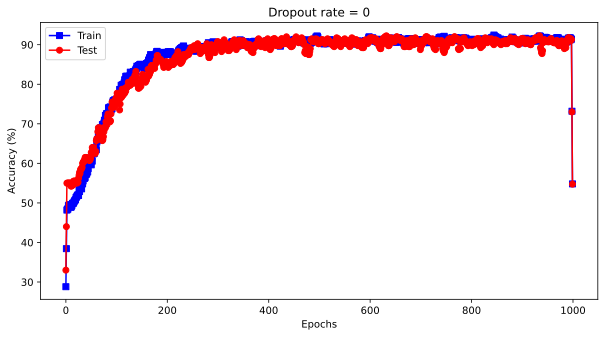

In [10]:
# Plot the results
fig = plt.figure(figsize=(10,5))  # Create a figure with a specified size

# Plot the smoothed training accuracy (blue squares) and smoothed test accuracy (red circles)
plt.plot(smooth(trainAcc), 'bs-')
plt.plot(smooth(testAcc), 'ro-')

# Add labels to the axes
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy (%)')  # Y-axis label

# Add a legend to distinguish between the training and test accuracy curves
plt.legend(['Train', 'Test'])

# Set the title of the plot with the dropout rate value
plt.title('Dropout rate = %g' % dropoutrate)  # The title includes the dropout rate

plt.show()  # Display the plot


# Now for the experiment!

In [11]:
# Run an experiment to test different dropout rates (Note: This takes approximately 3.5 minutes to run)

# Create an array of dropout rates ranging from 0 to 0.9 with a step of 0.1 (i.e., [0.0, 0.1, ..., 0.9])
dropoutRates = np.arange(10) / 10

# Create a numpy array to store the results, where each row represents a dropout rate and columns represent train and test accuracies
results = np.zeros((len(dropoutRates), 2))

# Loop over different dropout rates
for di in range(len(dropoutRates)):

  # Create and train the neural network model for the current dropout rate
  ANNQC, lossfun, optimizer = createANewModel(dropoutRates[di])
  trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimizer)

  # Store the mean accuracies from the last 100 epochs for both training and testing
  results[di, 0] = np.mean(trainAcc[-100:])
  results[di, 1] = np.mean(testAcc[-100:])


In [ ]:
# Plot the experiment results

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the average training and testing accuracies for different dropout rates
ax[0].plot(dropoutRates, results, 'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train', 'Test'])

# Plot the difference between training and testing accuracies for different dropout rates
ax[1].plot(dropoutRates, -np.diff(results, axis=1), 'o-')  # Calculate the difference and negate for positive values
ax[1].plot([0, 0.9], [0, 0], 'k--')  # Add a dashed line at y=0 for reference
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

# Show the plots
plt.show()


# Additional explorations

In [ ]:
# 1) Explore the effects of the smoothing parameter ('k' in the smooth() function). How much smoothing is "too much"? 
#    Note that this is a subjective judgment; the goal here is to gain some familiarity with smoothing filters.
# 
# 2) Dropout wasn't too impressive here. Perhaps it would be more helpful with a different number of nodes in the hidden
#    layer? Try running the experiment again using half as many hidden nodes, and twice as many nodes. Tip: take screenshots
#    of each result to compare the three runs.
# 